<a href="https://colab.research.google.com/github/vivekslair/experimentations/blob/main/hdfc_life_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
 
drive.mount('/gdrive')
# the project's folder
%cd /gdrive/'My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
import os, glob
import cv2
from matplotlib import pyplot as plt
import PIL
from PIL import ImageEnhance
from PIL import Image as pil_image

In [ ]:
os.chdir('HDFC_LIFE')

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical

In [ ]:
#Image augmentation with image generation from Keras
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
img_size=224
train_generator = datagen.flow_from_directory('train',
                                                    target_size=(img_size, img_size),
                                                    subset='training',
                                                    batch_size=32)

#Build test generator
val_generator = datagen.flow_from_directory('train',
                                                   target_size=(img_size, img_size),                                                   
                                                   subset='validation',
                                                   batch_size=32)

Found 473 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [ ]:
X, y = next(train_generator)

print('Input features shape', X.shape)
print('Actual labels shape', y.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Input features shape (32, 224, 224, 3)
Actual labels shape (32, 2)


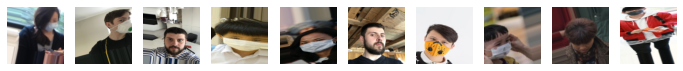

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow((X[i]).astype('uint8'))
    plt.axis('off')
plt.show()

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.applications.ResNet50(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=(224,224,3),
                                       weights='imagenet')

In [ ]:
#model.summary()

In [ ]:
len(model.layers)

175

In [ ]:
#Set pre-trained model layers to not trainable
for layer in model.layers[:12]:
    layer.trainable = False

In [ ]:
model.output

<KerasTensor: shape=(None, 7, 7, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [ ]:
#get Output layer of Pre0trained model
x = model.output

#Global average pool to reduce number of features and Flatten the output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
y = tf.keras.layers.Dense(1024,activation='relu')(x)

In [ ]:
#Add output layer
prediction = tf.keras.layers.Dense(2,activation='softmax')(y)

In [ ]:
#Using Keras Model class
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

In [ ]:
#Compile the model
final_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
#final_model.summary()

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('mask_resnet2.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [ ]:
final_model.fit_generator(train_generator, 
                          epochs=50,
                          steps_per_epoch= 473//32,
                          validation_data=val_generator,
                          validation_steps = 118//32, 
                          callbacks=[model_checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
14/14 [==============================] - 311s 22s/step - loss: 1.3881 - accuracy: 0.7428 - val_loss: 831.2414 - val_accuracy: 0.8438

Epoch 00001: val_accuracy improved from -inf to 0.84375, saving model to mask_resnet2.h5
Epoch 2/50
14/14 [==============================] - 301s 22s/step - loss: 0.3262 - accuracy: 0.8673 - val_loss: 497.8722 - val_accuracy: 0.8125

Epoch 00002: val_accuracy did not improve from 0.84375
Epoch 3/50
14/14 [==============================] - 301s 21s/step - loss: 0.2238 - accuracy: 0.9012 - val_loss: 13.8650 - val_accuracy: 0.8125

Epoch 00003: val_accuracy did not improve from 0.84375
Epoch 4/50
14/14 [==============================] - 298s 21s/step - loss: 0.1425 - accuracy: 0.9521 - val_loss: 5.1463 - val_accuracy: 0.8646

Epoch 00004: val_accuracy improved from 0.84375 to 0.86458, saving model to mask_resnet2.h5
Epoch 5/50
14/14 [==============================] - 302s 21s/step - loss: 0.1350 - accuracy: 0.9460 - val_loss: 15.8898 - val_accura

KeyboardInterrupt: ignored

In [ ]:
trained_model=tf.keras.models.load_model('mask_resnet2.h5')

In [ ]:
!ls

mask_resnet1.h5  mask_resnet.h5    predictions.csv  train
mask_resnet2.h5  predictions1.csv  test_data


In [ ]:
data = []
filenames = []
#df_test = pd.DataFrame(columns=['image_file'])
test_dir='/gdrive/MyDrive/HDFC_LIFE/test_data'
    # loop over the input images
images = os.listdir(test_dir)
for imageFileName in images:
        # load the image, pre-process it, and store it in the data list
    imageFullPath = os.path.join(test_dir, imageFileName)
        #print(imageFullPath)
    img = tf.keras.preprocessing.image.load_img(imageFullPath)
    arr = tf.keras.preprocessing.image.img_to_array(img)  # Numpy array with shape (...,..,3)
    arr = cv2.resize(arr, (224,224)) 
    data.append(arr)
    filenames.append(imageFileName)

In [ ]:
filenames

['13.jpg',
 '7.jpg',
 '5.jpg',
 '0.jpg',
 '16.jpg',
 '25.jpg',
 '4.jpg',
 '3.jpg',
 '1.jpg',
 '10.jpg',
 '23.jpg',
 '17.jpg',
 '26.jpg',
 '2.jpg',
 '21.jpg',
 '8.jpg',
 '12.jpg',
 '18.jpg',
 '44.jpg',
 '19.jpg',
 '43.jpg',
 '20.jpg',
 '38.jpg',
 '31.jpg',
 '41.jpg',
 '36.jpg',
 '6.jpg',
 '9.jpg',
 '27.jpg',
 '33.jpg',
 '40.jpg',
 '37.jpg',
 '30.jpg',
 '15.jpg',
 '34.jpg',
 '24.jpg',
 '29.jpg',
 '22.jpg',
 '45.jpg',
 '35.jpg',
 '28.jpg',
 '32.jpg',
 '42.jpg',
 '39.jpg',
 '14.jpg',
 '11.jpg']

In [ ]:
df_test = pd.DataFrame(columns=['image_file'])

In [ ]:
df_test['image_file'] = filenames

In [ ]:
import numpy as np

data=np.array(data)

In [ ]:
yFit=trained_model.predict(data)

In [ ]:
y_pred = np.round(yFit,decimals=0)

In [ ]:
predictions = []
for k in y_pred : 
  if k[0] == 1.0 :
    predictions.append(1)
  elif k[1] == 1.0 :
    predictions.append(0)

In [ ]:
df_test['predictions'] = predictions

In [ ]:
!ls

mask_resnet1.h5  mask_resnet.h5    predictions.csv  train
mask_resnet2.h5  predictions1.csv  test_data


In [ ]:
df_test.to_csv('predictions2.csv')